In [1]:
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import pandas as pd
import json
from fuzzywuzzy import process

In [5]:
# getting the first page of 200 movies
page = requests.get("https://editorial.rottentomatoes.com/guide/best-movies-of-all-time/")
# converting page into readable text file
soup = BeautifulSoup(page.content, "html.parser")
# umcomment to see html as text file
print(soup.prettify())

<!DOCTYPE html>
<html class="hitim" lang="en-US">
 <head prefix="og: http://ogp.me/ns# flixstertomatoes: http://ogp.me/ns/apps/flixstertomatoes#">
  <meta content="text/html; charset=utf-8" http-equiv="content-type"/>
  <!-- OneTrust Cookies Consent Notice start for rottentomatoes.com -->
  <script charset="UTF-8" crossorigin="anonymous" data-domain-script="7e979733-6841-4fce-9182-515fac69187f" integrity="sha384-TKdmlzVmoD70HzftTw4WtOzIBL5mNx8mXSRzEvwrWjpIJ7FZ/EuX758yMDWXtRUN" src="https://cdn.cookielaw.org/consent/7e979733-6841-4fce-9182-515fac69187f/otSDKStub.js" type="text/javascript">
  </script>
  <script type="text/javascript">
   function OptanonWrapper() { }
  </script>
  <!-- OneTrust Cookies Consent Notice end for rottentomatoes.com -->
  <!-- OneTrust IAB US Privacy (USP) -->
  <script ccpa-opt-out-geo="US" ccpa-opt-out-ids="USP" ccpa-opt-out-lspa="false" charset="UTF-8" src="https://cdn.cookielaw.org/opt-out/otCCPAiab.js" type="text/javascript">
  </script>
  <!-- OneTrust 

In [28]:
# creating an empty list to store individual movies
movies = []
titles_ratings = {}
# Loop through each movie row
for row in soup.find_all('tr'):
    movie_data = row.find('p', class_='apple-news-link-wrap movie')
    
    if movie_data:
        title = movie_data.find('a', class_='title').get_text(strip=True)
        score = int(movie_data.find('span', class_='score').strong.get_text(strip=True).strip("%"))
        year = movie_data.find('span', class_='year').get_text(strip=True)
        title = title + " " + year
        # Append data to the list
        titles_ratings[title] = {"rating": score}

# Print results
print(titles_ratings)

{'L.A. Confidential (1997)': {'rating': 99}, 'The Godfather (1972)': {'rating': 97}, 'Casablanca (1942)': {'rating': 99}, 'Seven Samurai (1954)': {'rating': 100}, 'Parasite (2019)': {'rating': 99}, "Schindler's List (1993)": {'rating': 98}, 'Top Gun: Maverick (2022)': {'rating': 96}, 'Toy Story 2 (1999)': {'rating': 100}, 'Chinatown (1974)': {'rating': 98}, 'On the Waterfront (1954)': {'rating': 99}, 'The Battle of Algiers (1966)': {'rating': 99}, 'Toy Story (1995)': {'rating': 100}, 'Rear Window (1954)': {'rating': 98}, 'Modern Times (1936)': {'rating': 98}, 'How to Train Your Dragon (2010)': {'rating': 99}, 'All About Eve (1950)': {'rating': 99}, 'Spirited Away (2001)': {'rating': 96}, 'Up (2009)': {'rating': 98}, 'The Third Man (1949)': {'rating': 99}, 'Spotlight (2015)': {'rating': 97}, 'Spider-Man: Into the Spider-Verse (2018)': {'rating': 97}, 'The Philadelphia Story (1940)': {'rating': 100}, 'Finding Nemo (2003)': {'rating': 99}, "Singin' in the Rain (1952)": {'rating': 100}, '1

In [29]:
# storing movie titles and their ratings as a hashmap in a new file
with open('title_ratings.txt', 'w') as title_ratings: 
     title_ratings.write(json.dumps(titles_ratings))

Your favorite movie: Avengers: Endgame
Your exploration percentage: 50

Recommended Movies:
- Zootopia (98)
- Mission: Impossible - Fallout (98)
- Raiders of the Lost Ark (94)
- Logan (93)
- Toy Story 2 (100)


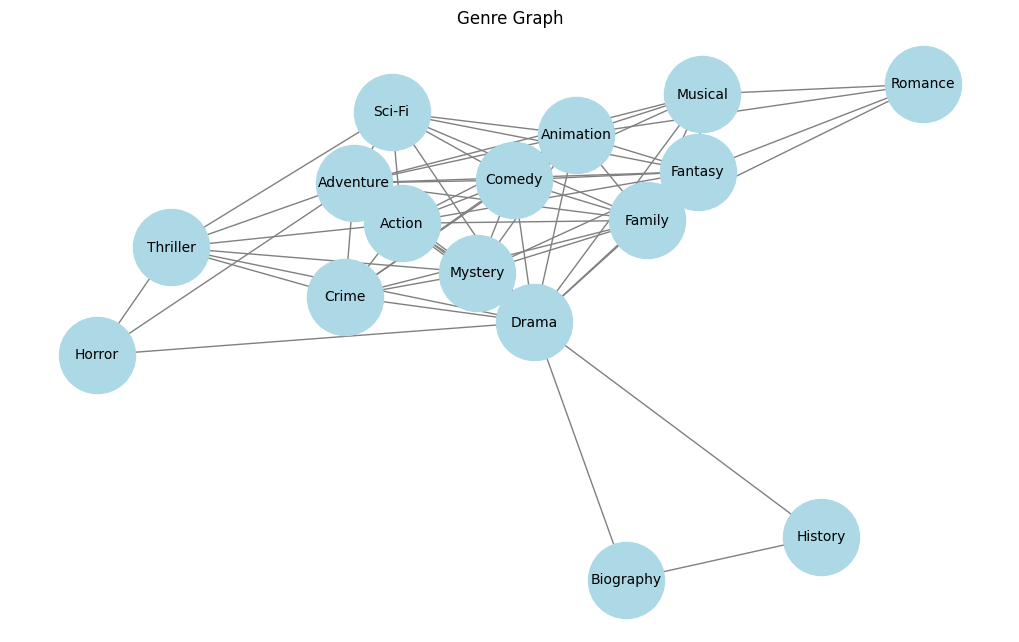

In [ ]:
import heapq
from collections import deque
import networkx as nx
import matplotlib.pyplot as plt

def build_genre_graph(movie_dict):
    """Builds a graph where genres are nodes and edges exist if movies share genres."""
    genre_graph = {}
    for movie, details in movie_dict.items():
        for genre in details['genres']:
            if genre not in genre_graph:
                genre_graph[genre] = set()
            genre_graph[genre].update(details['genres'])
            genre_graph[genre].remove(genre)
    return genre_graph

def bfs_genre_exploration(start_genres, genre_graph, max_depth):
    """Performs BFS to explore genres up to a certain depth."""
    queue = deque([(genre, 0) for genre in start_genres])
    explored_genres = set(start_genres)
    
    while queue:
        current_genre, depth = queue.popleft()
        if depth >= max_depth:
            continue
        for neighbor in genre_graph.get(current_genre, []):
            if neighbor not in explored_genres:
                explored_genres.add(neighbor)
                queue.append((neighbor, depth + 1))
    
    return explored_genres

def get_movie_recommendations(movie_dict, fav_movie, exploration_pct):
    if fav_movie not in movie_dict:
        print("Movie not found in database.")
        return []
    
    genre_graph = build_genre_graph(movie_dict)  # Build genre graph
    fav_genres = set(movie_dict[fav_movie]['genres'])  # Get favorite movie's genres
    
    # Define genre overlap rules based on exploration percentage
    if exploration_pct <= 20:
        min_genre_overlap = min(3, len(fav_genres))  # At least 3, or all if less than 3
    elif exploration_pct <= 50:
        min_genre_overlap = 2  # At least 2 overlapping genres
    elif exploration_pct <= 75:
        min_genre_overlap = 1  # At least 1 overlapping genre
    else:
        min_genre_overlap = 0  # No overlap required
    
    relevant_genres = bfs_genre_exploration(fav_genres, genre_graph, 3)  # Explore genres
    
    # Gather movies that belong to relevant genres and check genre overlap
    candidate_movies = []
    for movie, details in movie_dict.items():
        if movie == fav_movie:
            continue
        movie_genres = set(details['genres'])
        overlap_count = len(fav_genres & movie_genres)  # Count overlapping genres
        
        if overlap_count <= min_genre_overlap:
            candidate_movies.append((movie, overlap_count, details['rating']))
    
    # Sort movies by genre overlap first, then by rating as a tiebreaker
    candidate_movies.sort(key=lambda x: (-x[1], -x[2]))  # Sort by overlap (descending), then rating
    
    return [(movie, rating) for movie, _, rating in candidate_movies[:5]]  # Return top 5 movies with ratings

    # if fav_movie not in movie_dict:
    #     print("Movie not found in database.")
    #     return []
    
    # genre_graph = build_genre_graph(movie_dict)
    # fav_genres = set(movie_dict[fav_movie]['genres'])
    
    # # Define depth of exploration based on percentage
    # if exploration_pct <= 20:
    #     max_depth = 1  # Strictly same genre
    # elif exploration_pct <= 50:
    #     max_depth = 2  # Explore related genres
    # else:
    #     max_depth = 3  # Broader exploration
    
    # relevant_genres = bfs_genre_exploration(fav_genres, genre_graph, max_depth)
    
    # # Gather movies that belong to relevant genres
    # candidate_movies = []
    # for movie, details in movie_dict.items():
    #     if movie == fav_movie:
    #         continue
    #     if any(genre in relevant_genres for genre in details['genres']):
    #         candidate_movies.append((movie, details['rating']))
    
    # # Sort by rating
    # top_movies = heapq.nlargest(5, candidate_movies, key=lambda x: x[1])
    # return [(movie, rating) for movie, rating in top_movies]

# Sample movie database
with open("ratings_genres.txt", "r") as rating_genre:
    movie_db = json.load(rating_genre)

def display_genre_graph(genre_graph):
    """Displays the genre graph using NetworkX and Matplotlib."""
    G = nx.Graph()
    for genre, neighbors in genre_graph.items():
        for neighbor in neighbors:
            G.add_edge(genre, neighbor)
    
    plt.figure(figsize=(10, 6))
    nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', font_size=10, node_size=3000)
    plt.title("Genre Graph")
    plt.show()

# Taking user input
fav_movie = input("Enter your favorite movie: ")
# Use the fuzzywuzzy library to pick out the closest movie title. Grabs best match and string relating to it
fuzzed_fav_movie = process.extract(fav_movie, movie_db.keys())[0][0]
try:
    exploration_pct = int(input("Enter exploration percentage (0-100): "))
    if exploration_pct < 0 or exploration_pct > 100:
        raise ValueError("Exploration percentage must be between 0 and 100.")
    
    recommendations = get_movie_recommendations(movie_db, fuzzed_fav_movie, exploration_pct)
    
    if recommendations:
        print(f"Your favorite movie: {fuzzed_fav_movie}\nYour exploration percentage: {exploration_pct}")
        print("\nRecommended Movies:")
        for movie, rating in recommendations:
            print(f"- {movie} ({rating})")
    else:
        print("No recommendations available.")

    # Display genre graph
    genre_graph = build_genre_graph(movie_db)
    display_genre_graph(genre_graph)

except ValueError as e:
    print(f"Invalid input: {e}")
